In [23]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [24]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)

## Load data

In [25]:
batch_size = 32
img_height = 32  #all img in our dataset are of 32x32 default
img_width = 32

In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/devanagari-character-dataset-large/dhcd/train",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 78200 files belonging to 46 classes.


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/devanagari-character-dataset-large/dhcd/test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale'
)

Found 13800 files belonging to 46 classes.


In [28]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '5', '6', '7', '8', '9']


### Reading labels csv file
This file contains the mapping of above class_names with the actual names of the character

In [29]:
labels_csv = pd.read_csv("/kaggle/input/devanagari-character-dataset-large/labels.csv")
labels_csv.tail()

,Class,Label,Devanagari label,Phonetic,Type
41,41,patalosaw,स,sa,CONSONANT
42,42,ha,ह,ha,CONSONANT
43,43,ksha,क्ष,kṣa,CONSONANT
44,44,tra,त्र,tra,CONSONANT
45,45,gya,ज्ञ,jña,CONSONANT


In [30]:
labels_csv.loc[45, 'Devanagari label']

'ज्ञ'

ष
थ
९
घ
ब
८
ल
८
म


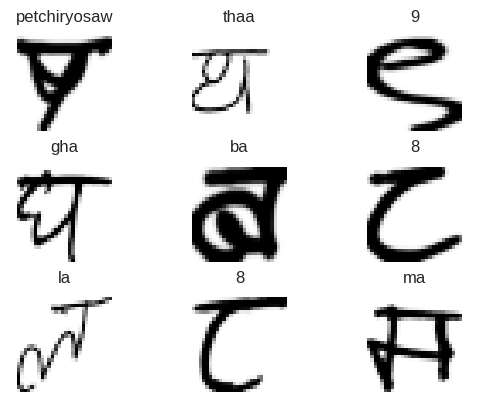

In [31]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
#     print(images[i].numpy().astype("uint8").shape)
#     print(labels[i])    #folder ko index print garxa
#     plt.title(class_names[labels[i]]) #folder ko naam print garxa
    class_name = int(class_names[labels[i]])
    print(labels_csv.loc[class_name, 'Devanagari label'])
    plt.title(labels_csv.loc[class_name, 'Label'])
    plt.axis("off")

## Configure the dataset for performance

In [32]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating Model

In [33]:
num_classes = len(class_names)

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load DenseNet121 with ImageNet weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Create a Sequential model
model = Sequential()

# Convert grayscale to 3 channels by repeating the grayscale image 3 times
model.add(layers.Conv2D(3, (3, 3), padding='same', input_shape=(img_width, img_height, 1)))

# Add DenseNet121 as the base model
model.add(base_model)

# Add custom classification layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(num_classes, activation='softmax'))

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 46)                  │          11,822 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,311,756 (27.89 MB)

 Trainable params: 7,228,108 (27.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 3)           │              30 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 1, 1, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 46)                  │          11,822 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,311,756 (27.89 MB)

 Trainable params: 7,228,108 (27.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

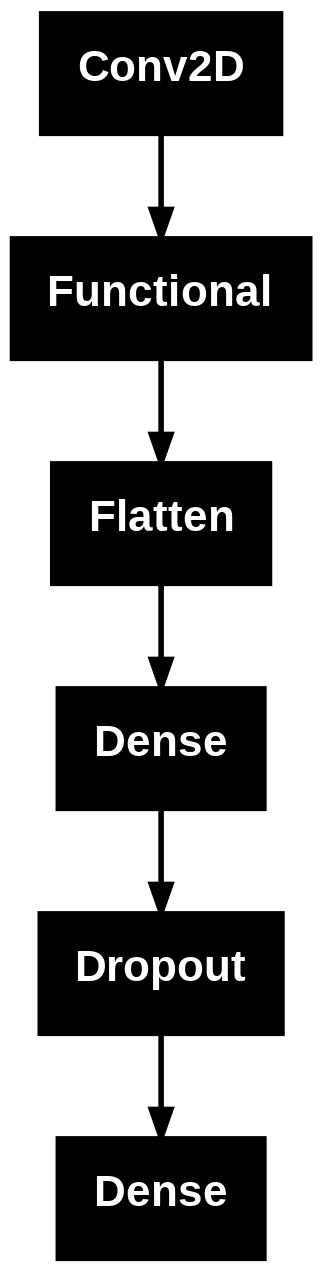

In [35]:
keras.utils.plot_model(model, "nepali_ocr_model.png")

## Compiling the Model

## Train the Model

In [36]:
from tensorflow.keras.optimizers import Adam
import time

epochs = 10
time1 = time.time()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=10
)

time2 = time.time()

print("Train time = ", (time2 - time1) / 60, "min")


Epoch 1/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 249s 55ms/step - accuracy: 0.5246 - loss: 1.9701 - val_accuracy: 0.9906 - val_loss: 0.0526
Epoch 2/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9558 - loss: 0.1647 - val_accuracy: 0.9812 - val_loss: 0.0443
Epoch 3/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9767 - loss: 0.0860 - val_accuracy: 0.9781 - val_loss: 0.0962
Epoch 4/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 30ms/step - accuracy: 0.9835 - loss: 0.0591 - val_accuracy: 0.9812 - val_loss: 0.0563
Epoch 5/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9879 - loss: 0.0445 - val_accuracy: 0.9875 - val_loss: 0.0443
Epoch 6/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9902 - loss: 0.0342 - val_accuracy: 0.9937 - val_loss: 0.0226
Epoch 7/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9915 - loss: 0.0325 - val_accuracy: 0.9812 - val_loss: 0.1604
Epoch 8/10
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - accuracy: 0.9929 

## Visualize training results
Create plots of the loss and accuracy on the training and validation sets:

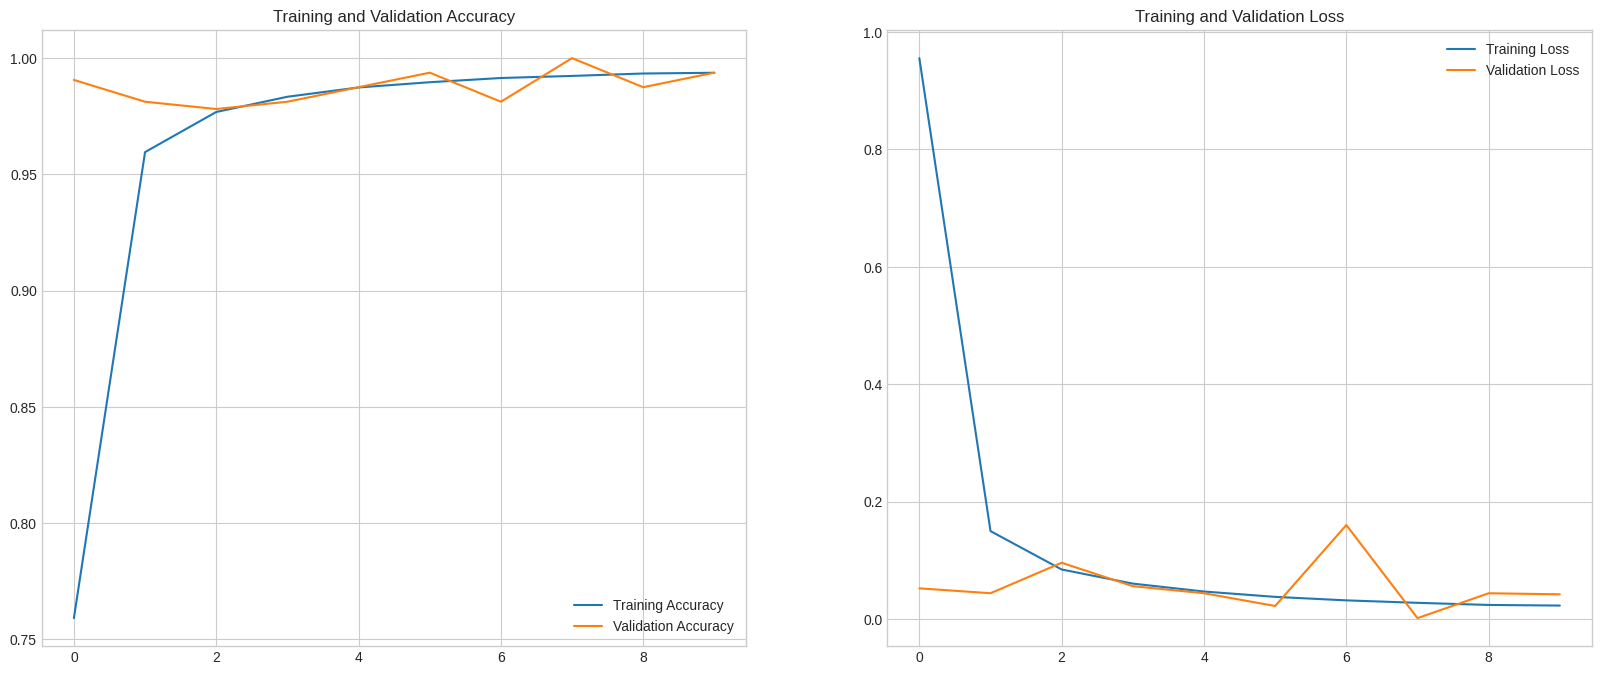

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving the Model

In [38]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model_ocr.h5')

### Reload a fresh Keras model from the saved model:

In [39]:

new_model1 = tf.keras.models.load_model('/kaggle/input/my-model/tensorflow2/default/1/my_model.h5')

# Check its architecture
new_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 46)                  │          11,822 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,125,648 (4.29 MB)

 Trainable params: 1,125,646 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Saving in HDF5 format
Keras provides a basic save format using the HDF5 standard.

### Now lets check if our loaded model performs as it didi on test set earlier on training.

<ipython-input-40-78b66807908f>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Actual- ध   Prediction- ध
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual- ष   Prediction- ष
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual- ह   Prediction- ह
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Actual- ह   Prediction- ह
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual- फ   Prediction- फ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual- ट   Prediction- ट
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual- थ   Prediction- थ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual- ठ   Prediction- ठ
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual- ण   Prediction- ण


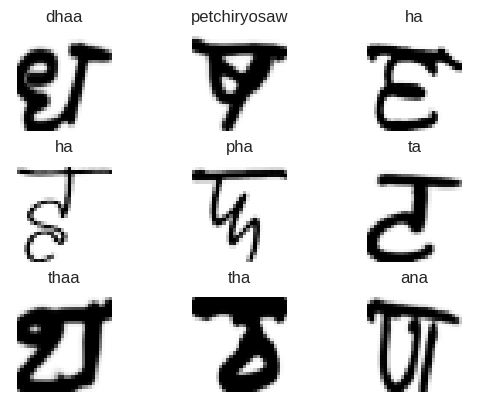

In [40]:
plt.style.use('seaborn-whitegrid')
# r=3
# c=3
# fig = plt.figure(figsize=(20, 20))
# for i in range(r*c):
#     plt.subplot(r, c, i+1)
#     lbl = val_ds[i][1][i]
#     img = val_ds[i][0][i]
#     img = img.reshape(1, 32, 32, 1)
#     prediction = model.predict(img)
#     prediction = np.argmax(prediction)
#     title = f"Pred: {classes[prediction]} Real: {classes[np.argmax(lbl)]}"
#     plt.title(title)
#     plt.imshow(img.reshape(32, 32))
# plt.show()

for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
#     print(images[i].numpy().astype("uint8").shape)
#     print(labels[i])    #folder ko index print garxa
#     plt.title(class_names[labels[i]]) #folder ko naam print garxa
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    class_name = int(class_names[labels[i]])
    
    predictions = new_model1.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predict = int(class_names[np.argmax(score)])
    print("Actual-" ,labels_csv.loc[class_name, 'Devanagari label']," ", "Prediction-" ,labels_csv.loc[predict, 'Devanagari label'])
    
    
    plt.title(labels_csv.loc[class_name, 'Label'])
    plt.axis("off")

## Predicting on new data

In [41]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from termcolor import colored

# Get true labels and predictions on the validation set
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
num_classes = conf_matrix.shape[0]

# Initialize TP, TN, FP, FN
TP = np.diag(conf_matrix)  # True Positives
FP = conf_matrix.sum(axis=0) - TP  # False Positives
FN = conf_matrix.sum(axis=1) - TP  # False Negatives
TN = conf_matrix.sum() - (TP + FP + FN)  # True Negatives

# Calculate Precision, Recall, and F1-score per class
precision = np.where((TP + FP) > 0, TP / (TP + FP), 0)
recall = np.where((TP + FN) > 0, TP / (TP + FN), 0)
f1_score = np.where((precision + recall) > 0, 2 * (precision * recall) / (precision + recall), 0)

# Create a DataFrame for better readability
metrics_matrix = pd.DataFrame(
    {
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "Total": TP + TN + FP + FN,  # Total for each class
    }
)

# Display the class-wise matrix with color
print(colored("\nFinal TP, TN, FP, FN, Precision, Recall, F1-Score Matrix:", "cyan", attrs=["bold"]))
print(tabulate(metrics_matrix, headers="keys", tablefmt="fancy_grid"))

# Compute overall TP, TN, FP, FN for all classes combined
total_TP = TP.sum()
total_TN = TN.sum()
total_FP = FP.sum()
total_FN = FN.sum()
total_samples = total_TP + total_TN + total_FP + total_FN

# Calculate overall Precision, Recall, and F1-Score
overall_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
overall_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
overall_f1_score = (
    2 * (overall_precision * overall_recall) / (overall_precision + overall_recall)
    if (overall_precision + overall_recall) > 0
    else 0
)

# Create a matrix for overall results
overall_matrix = [
    ["", "Predicted Positive", "Predicted Negative"],
    ["Actual Positive", f"TP = {colored(total_TP, 'green')}", f"FN = {colored(total_FN, 'red')}"],
    ["Actual Negative", f"FP = {colored(total_FP, 'yellow')}", f"TN = {colored(total_TN, 'green')}"],
    ["Total", f"{total_samples}", ""],
]

# Display the overall matrix
print(colored("\nFinal TP, TN, FP, FN (Overall Matrix Representation):", "cyan", attrs=["bold"]))
print(tabulate(overall_matrix, tablefmt="fancy_grid"))

# Print overall Precision, Recall, and F1-Score
print(colored(f"\nOverall Precision: {overall_precision:.4f}", "green", attrs=["bold"]))
print(colored(f"Overall Recall: {overall_recall:.4f}", "blue", attrs=["bold"]))
print(colored(f"Overall F1-Score: {overall_f1_score:.4f}", "magenta", attrs=["bold"]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
This image most likely belongs to ब with a 100.00 percent confidence.


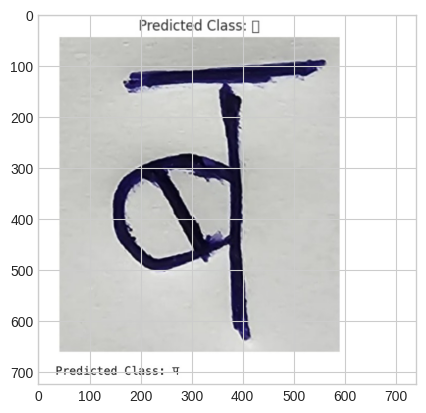

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define classes for model predictions
classes = [
    'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध',
    'क', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल',
    'व', 'ख', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ', 'ग',
    'घ', 'ङ', 'च', 'छ', 'ज', 'झ', '०', '१', '२', '३',
    '४', '५', '६', '७', '८', '९'
]

# Preprocess image for edge detection and model input
def preprocess_image_for_model(img_path):
    # Load the image
    image = cv2.imread(img_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use adaptive thresholding to create a binary image
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If there are any contours, find the largest one
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Crop the image to the bounding rectangle of the largest contour
        cropped_image = image[y:y+h, x:x+w]
    else:
        cropped_image = image  # If no contours found, use the original image
    
    # Convert cropped image to grayscale and threshold
    cropped_gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    _, final_image = cv2.threshold(cropped_gray, 128, 255, cv2.THRESH_BINARY_INV)
    
    # Resize the final image to the input size of the model (32x32)
    final_resized_image = cv2.resize(final_image, (32, 32))
    
    return final_resized_image

# Load the trained model (update with your model path)
new_model1 = load_model('/kaggle/input/my-model/tensorflow2/default/1/my_model.h5')

# Image path for the input
img_path = '/kaggle/input/zberbrrgrg/WhatsApp Image 2024-11-03 at 18.59.29_9a6d9929.jpg'

# Preprocess and get processed image for model input
img = preprocess_image_for_model(img_path)

img1 = tf.keras.utils.load_img(
    img_path,
    
)


plt.imshow(img1)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model1.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to क with a 100.00 percent confidence.


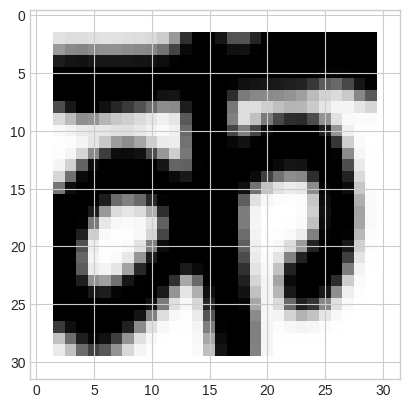

In [43]:
img = tf.keras.utils.load_img(
    "/kaggle/input/devanagari-character-dataset-large/dhcd/test/10/11035.png",
    target_size=(img_height, img_width),
    color_mode='grayscale',
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model1.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)

InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-44-44d745b0b729>", line 12, in <cell line: 12>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

Depth of output must be a multiple of the number of groups: 32 vs 3

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-44-44d745b0b729>", line 12, in <cell line: 12>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_637783[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_637810]

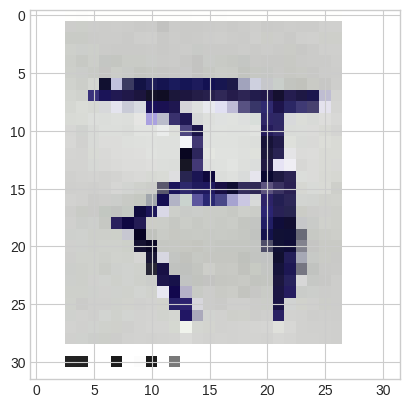

In [44]:
img = tf.keras.utils.load_img(
    "/kaggle/input/4gtgtg45g/WhatsApp Image 2024-11-03 at 18.59.29_2b84a9eb.jpg", target_size=(img_height, img_width)
)

plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
# print(img_array[])
# print(255-img_array)
img_array = 255-img_array
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model1.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)

In [ ]:
img = tf.keras.utils.load_img(
    "/kaggle/input/nepali-devanagari-for-predicting/four-modified.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)

In [ ]:
img = tf.keras.utils.load_img(
    "/kaggle/input/nepali-devanagari-for-predicting/ga-modified.jpg", target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_name = int(class_names[np.argmax(score)])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(labels_csv.loc[class_name, 'Devanagari label'], 100 * np.max(score))
)

## Saving Model in HDF5 format

In [ ]:
# Save the entire model as a SavedModel.
model.save('my_model.h5')

In [ ]:
/kaggle/working/

In [ ]:
!zip -r file.zip /kaggle/working/